In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.ndimage
import leggps

import matplotlib.pylab as plt
%matplotlib inline

# interpolation 

### construct a few independent one-d observations

In [46]:
sample1_ts = np.cumsum(npr.exponential(size=1000)+.01) # <-- irregularly spaced observation times!
sample1_vals = sp.ndimage.gaussian_filter1d(npr.randn(1000),10,axis=0)[:,None]

sample2_ts = np.cumsum(npr.exponential(size=100)+.1)
sample2_vals = sp.ndimage.gaussian_filter1d(npr.randn(100),10,axis=0)[:,None]

Note that `sample1_vals` and `sample2_vals` **MUST** be matrices, not vectors:

In [47]:
print(sample1_ts.shape)
print(sample1_vals.shape)
print(sample2_ts.shape)
print(sample2_vals.shape)

(1000,)
(1000, 1)
(100,)
(100, 1)


Look at one of them

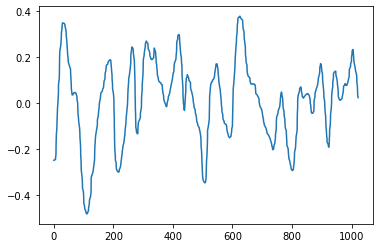

In [48]:
plt.plot(sample1_ts,sample1_vals)

### put them together

In [49]:
all_ts = [sample1_ts,sample2_ts]
all_vals=[sample1_vals,sample2_vals]

### train a model

train a rank-5 LEG model on it

In [50]:
rank=5

In [9]:
result = leggps.training.fit(all_ts,all_vals,rank)

better yet, fit a rank-5 LEG model and get live updates (only works if you have installed tqdm)

In [51]:
# this picks a RANDOM initial condition somewhat based on the data
# often works ok
result = leggps.training.fit(all_ts,all_vals,rank,use_tqdm_notebook=True,maxiter=100)

look at the different nats we found as we trained using BFGS.

here `nats = - log likelihood / nobservations`.   lower is better

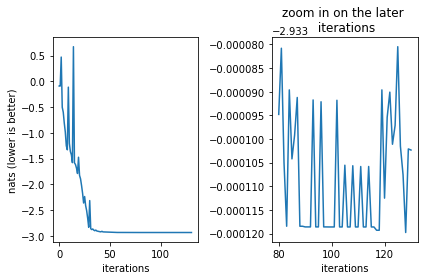

In [52]:
plt.subplot(1,2,1)
iterations=range(len(result['nats']))
plt.plot(iterations,result['nats'])
plt.xlabel('iterations')
plt.ylabel("nats (lower is better)")

plt.subplot(1,2,2)
plt.plot(iterations[80:],result['nats'][80:])
plt.xlabel('iterations')
plt.title("zoom in on the later \n iterations")

plt.tight_layout()

Looking at these losses, it seems like maybe we don't need to train anymore.  

In [53]:
print("training result:",result['message'])

training result: Desired error not necessarily achieved due to precision loss.


That means we're as good as we're going to get with the numerical precision we have.  Let's train a little longer, just for fun.

In [54]:
# result['params'] is the model learned in the first round of training
# here we feed it back into the trainer, which uses it as an initial condition...
result2 = leggps.training.fit(all_ts,all_vals,rank,use_tqdm_notebook=True,maxiter=100,**result['params']) 

What did nats look like as we did a second round of training?

Text(0.5, 15.0, 'iterations')

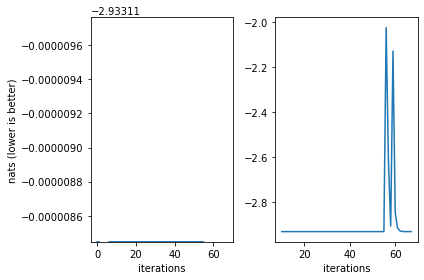

In [55]:
plt.subplot(1,2,1)
iterations=range(len(result2['nats']))
plt.plot(iterations,result2['nats'])
plt.ylim(np.min(result2['nats']),np.min(result['nats']))
plt.xlabel('iterations')
plt.ylabel("nats (lower is better)")

plt.subplot(1,2,2)
plt.plot(iterations[10:],result2['nats'][10:])
plt.tight_layout()
plt.xlabel('iterations')

Looks like at the end we weren't finding any better solutions.  BFGS will always return the best solution that it came across (not necessarily the last one, which may not be the best).

Let's see what the optimizer had to say:

In [56]:
print("training result:",result2['message'])

training result: Desired error not necessarily achieved due to precision loss.


Yeah still the same.

In [57]:
model = result2['params']

A LEG model has four parameters: N,R,B,Lambda.  We can look at all of them, though they may not mean too much.

In [58]:
print(model['N'])
print(model['R'])
print(model['B'])
print(model['Lambda'])

[[ 0.3984529   0.          0.          0.          0.        ]
 [-0.81805326  0.72561147  0.          0.          0.        ]
 [ 0.28287328 -0.25000389  0.19316993  0.          0.        ]
 [-0.83780907 -0.51102015 -0.30438022  0.7252802   0.        ]
 [-0.06649373 -0.05887818 -0.25181645 -0.10863718  0.00128506]]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.53744458  0.          0.          0.          0.        ]
 [-0.33163568  0.15165069  0.          0.          0.        ]
 [ 0.39179702  0.21970584 -0.21030239  0.          0.        ]
 [ 0.11300723  0.01940004 -0.23337053 -0.01117643  0.        ]]
[[-0.07199512 -0.05734224 -0.12131471 -0.01262208 -0.07816816]]
[[0.00610488]]


### forecasting/interpolating

Now that we've trained our model on that dataset, we can do forecasting on any dataset.  Let's make an interesting one.  We'll start by making a regular looking timeseries

In [59]:
sample3_ts = np.cumsum(np.r_[npr.exponential(size=500)])
sample3_vals = sp.ndimage.gaussian_filter1d(npr.randn(500),10,axis=0)[:,None]

But then we'll chop out the middle

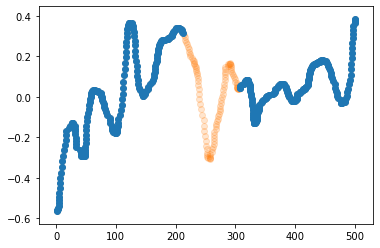

In [60]:
sample3_ts_chopped = np.r_[sample3_ts[:200],sample3_ts[-200:]]
sample3_vals_chopped = np.concatenate([sample3_vals[:200],sample3_vals[-200:]])

plt.scatter(sample3_ts,sample3_vals,color='C1',alpha=.2)
plt.scatter(sample3_ts_chopped,sample3_vals_chopped,color='C0')

Let's see how the model interpolates and forecasts with this data.  We pick a set of times we're interested in.  We feed it the censored observations and the model.  It spits out predictions:

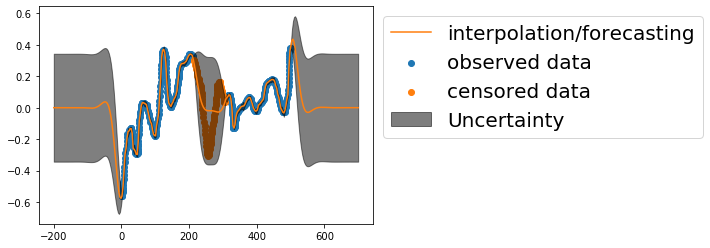

In [61]:
forecast_times=np.r_[-200:700:300j]
means,variances=leggps.posterior_predictive(sample3_ts_chopped,sample3_vals_chopped,forecast_times,**model)
plt.scatter(sample3_ts_chopped,sample3_vals_chopped,label='observed data')
plt.scatter(sample3_ts[200:-200],sample3_vals[200:-200],label='censored data')
plt.plot(forecast_times,means,'C1',label='interpolation/forecasting')
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(variances[:,0,0]),
                 means[:,0]-2*np.sqrt(variances[:,0,0]),
                color='black',alpha=.5,label='Uncertainty')


plt.legend(bbox_to_anchor=[1,1],fontsize=20)

# smoothing

For smoothing, let's look at datasets which have some noise on top of them.

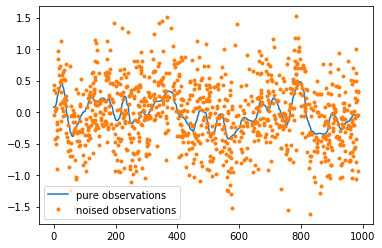

In [37]:
sample1_ts = np.cumsum(npr.exponential(size=1000)+.01)
sample1_vals = sp.ndimage.gaussian_filter1d(npr.randn(1000),10,axis=0)[:,None]
sample1_vals_plusnoise = sample1_vals+.5*npr.randn(1000)[:,None]

plt.plot(sample1_ts,sample1_vals,label='pure observations')
plt.plot(sample1_ts,sample1_vals_plusnoise,'.',label='noised observations')
plt.legend()

In [38]:
rank=5
result = leggps.training.fit([sample1_ts],[sample1_vals_plusnoise],rank,use_tqdm_notebook=True)

Look at training process...

Desired error not necessarily achieved due to precision loss.


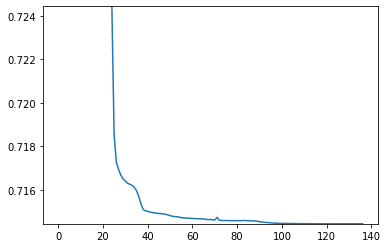

In [39]:
plt.plot(result['nats'])
plt.ylim(np.min(result['nats']),np.min(result['nats'])+.01)
print(result['message'])

Looks fine.  This error about precision loss always happens.  Let's store this model and use it.

In [40]:
model = result['params']

Let's try to smooth the data (in this case, the same data we trained on)

In [41]:
forecast_times=np.r_[-200:600]
means,variances=leggps.posterior_predictive(sample1_ts,sample1_vals_plusnoise,forecast_times,**model)

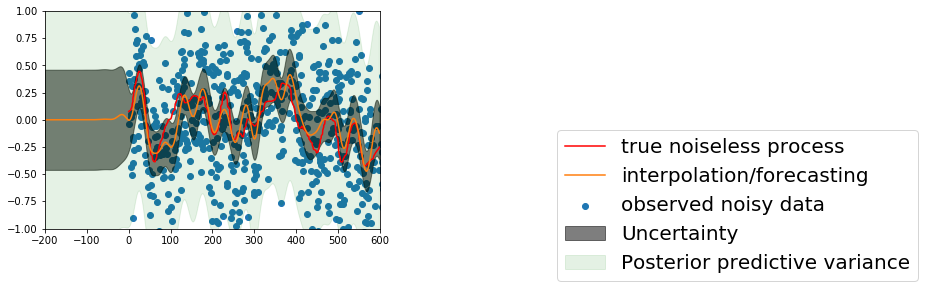

In [42]:
plt.plot(sample1_ts,sample1_vals,'r-',label='true noiseless process')
plt.scatter(sample1_ts,sample1_vals_plusnoise,label='observed noisy data')
plt.plot(forecast_times,means,'C1',label='interpolation/forecasting')
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(variances[:,0,0]),
                 means[:,0]-2*np.sqrt(variances[:,0,0]),
                color='black',alpha=.5,label='Uncertainty')


v2 = variances + model['Lambda']@model['Lambda'].T
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(v2[:,0,0]),
                 means[:,0]-2*np.sqrt(v2[:,0,0]),
                color='green',alpha=.1,label='Posterior predictive variance')

plt.xlim(-200,600)
plt.ylim(-1,1)

plt.legend(bbox_to_anchor=[1.5,.5],fontsize=20)

This shows the difference between the posterior predictive uncertainty and the posterior predictive variances.  T

- The interpolation/forecast (orange) tells us our guess for the true noiseless process
- The posterior predictive uncertainty (gray) tells us how uncertain we are about the orange curve
- The posterior predictive variances (green) tells us how uncertain we should be about the value of a new observation at a particular time.  

Another way to think about the learned model is to look directly at the LEG covariance.  

In [43]:
taus=np.r_[0:400]
C_LEG=leggps.C_LEG(taus,**model)

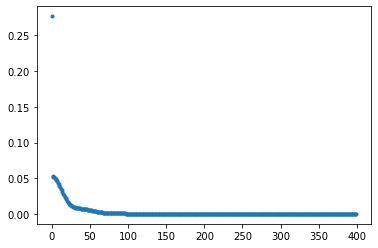

In [44]:
plt.plot(taus,C_LEG[:,0,0],'.')

Here we see that the marginal variance ($C(0)$) is much higher than $C(\tau),\tau>0$.  That's because of the observation noise.  The observation noise adds a spike at zero.

Let's zoom in:

(0, 0.05283452340258016)

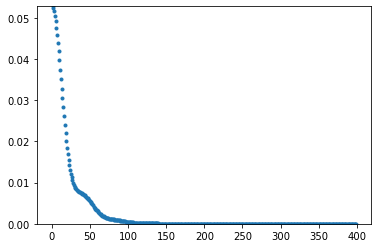

In [45]:
plt.plot(taus,C_LEG[:,0,0],'.')
plt.ylim(0,C_LEG[1,0,0])

# speed test

In [2]:
m=1000000
import tensorflow as tf
import leggps.cr
import numpy as np
Rs=tf.convert_to_tensor(np.zeros((m,3,3)) + np.eye(3)[None,:,:],dtype=tf.float32)
Os=tf.convert_to_tensor(np.zeros((m-1,3,3)),dtype=tf.float32)

@tf.function(autograph=False)
def go(Rs,Os):
    return leggps.cr.decompose(Rs,Os)

%time foo=go(Rs,Os)
%time foo=go(Rs,Os)

CPU times: user 2.43 s, sys: 153 ms, total: 2.59 s
Wall time: 1.41 s
CPU times: user 1.55 s, sys: 107 ms, total: 1.66 s
Wall time: 447 ms
